##  1. Load the dataset
Importing required libraries and loading the event log


In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from pm4py.objects.log.importer.xes.importer import apply as import_xes
import pm4py
from scipy.stats import spearmanr

log = import_xes("BPI_Challenge_2012.xes")
df = pm4py.convert_to_dataframe(log)
df.head()

C:\Users\mdomi\PycharmProjects\BIS\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
parsing log, completed traces :: 100%|██████████| 13087/13087 [00:13<00:00, 948.43it/s] 


,org:resource,lifecycle:transition,concept:name,time:timestamp,case:REG_DATE,case:concept:name,case:AMOUNT_REQ
0,112,COMPLETE,A_SUBMITTED,2011-10-01 00:38:44.546000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000
1,112,COMPLETE,A_PARTLYSUBMITTED,2011-10-01 00:38:44.880000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000
2,112,COMPLETE,A_PREACCEPTED,2011-10-01 00:39:37.906000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000
3,112,SCHEDULE,W_Completeren aanvraag,2011-10-01 00:39:38.875000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000
4,NaN,START,W_Completeren aanvraag,2011-10-01 11:36:46.437000+00:00,2011-10-01 00:38:44.546000+00:00,173688,20000


## 2. Executing a processing step related to case-level analysis
## 2.1 Inital log exploration
Statistic which can describe loaded dataset and be useful to understanding the input

In [2]:
print("Total events:", len(df))
print("Unique cases:", df["case:concept:name"].nunique())
print("Unique activities:", df["concept:name"].nunique())
print("Time range:", df["time:timestamp"].min(), "to", df["time:timestamp"].max())
print("Distinct resources:", df["org:resource"].nunique())
print("Lifecycle transitions:", df["lifecycle:transition"].nunique())


Total events: 262200
Unique cases: 13087
Unique activities: 24
Time range: 2011-10-01 00:38:44.546000+00:00 to 2012-03-14 16:04:54.681000+00:00
Distinct resources: 68
Lifecycle transitions: 3


### 2.2 Event Characteristics
Top activity frequency can show which of activities (related to the W_ subprocess) are most common in loan process

Distribution of events per case helps visualize the complexity and variability of individual cases by showing how many events occur per loan application.

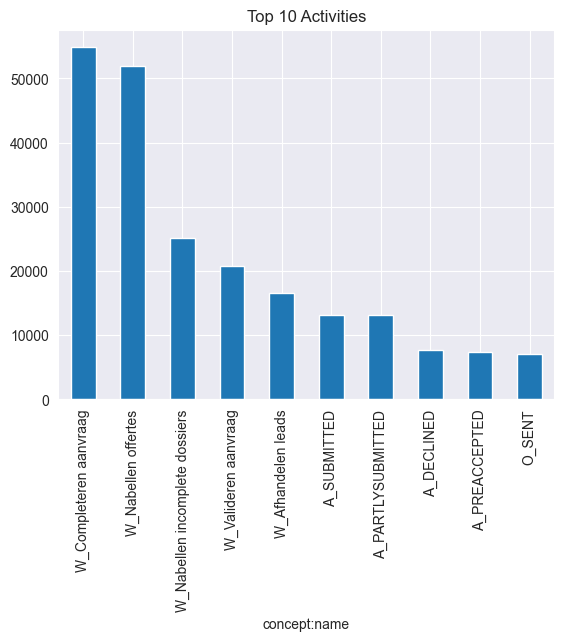

Text(0, 0.5, 'Number of Cases')

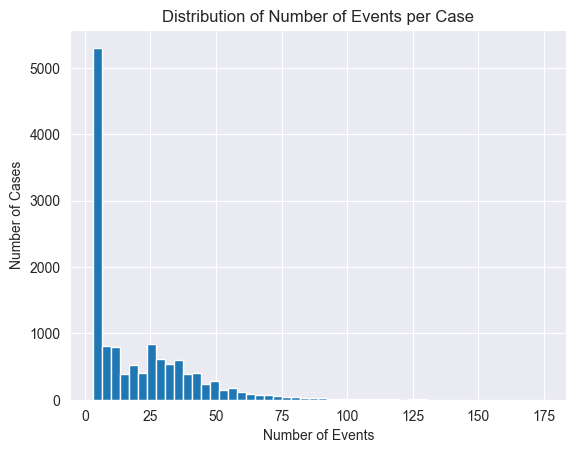

In [3]:
df["concept:name"].value_counts().head(10).plot(kind="bar", title="Top 10 Activities")
plt.show()

case_lengths = df.groupby("case:concept:name").size()
case_lengths.hist(bins=50)
plt.title("Distribution of Number of Events per Case")
plt.xlabel("Number of Events")
plt.ylabel("Number of Cases")


## 3. Filtering and Preprocessing
### 3.1 Mapping the requested loan amount (AMOUNT_REQ) to each case
This step extracts the requested loan amount from each case trace and maps it to the event-level DataFrame so that it can be included in downstream analysis and modeling.

In [4]:
amount_dict = {
    trace.attributes["concept:name"]: trace.attributes.get("AMOUNT_REQ", None)
    for trace in log
}
df["AMOUNT_REQ"] = df["case:concept:name"].map(amount_dict)
df["AMOUNT_REQ"] = pd.to_numeric(df["AMOUNT_REQ"], errors="coerce")

### 3.2 Mapping the appropriate outcome for each case
This function assigns a final outcome label (approved, declined, or cancelled) to each case based on the activities it contains, enabling outcome-based segmentation and analysis.

In [5]:
def get_outcome(event_series):
    events = event_series.tolist()
    for outcome in ["A_APPROVED", "A_DECLINED", "A_CANCELLED"]:
        if outcome in events:
            return outcome
    return "UNKNOWN"

df["outcome"] = (
    df.groupby("case:concept:name")["concept:name"]
    .apply(get_outcome)
    .reset_index(drop=True)
)


###  3.3 Filtering to keep only relevant final outcomes
(A_APPROVED, A_DECLINED, A_CANCELLED)

includes data cleaning

and timestamp normalization - all timestamps were converted into consistent datetime formats.


In [6]:
valid_outcomes = ["A_APPROVED", "A_DECLINED", "A_CANCELLED"]

df["time:timestamp"] = pd.to_datetime(df["time:timestamp"])
df["AMOUNT_REQ"] = pd.to_numeric(df["case:concept:name"]
                   .map(amount_dict), errors="coerce")
df = df.dropna(subset=["AMOUNT_REQ"])
df["outcome"] = (
    df.groupby("case:concept:name")["concept:name"]
      .transform(get_outcome)
)
df = df[df["outcome"].isin(valid_outcomes)]

### 3.4 Redundancy Detection
The following code identifies redundant pairs of consecutive activities—i.e., activity transitions that occur in the same order in every case. These are considered structurally unnecessary and candidates for removal.

In [7]:
transitions = df.groupby("case:concept:name")["concept:name"] \
                 .apply(lambda seq: list(zip(seq, seq[1:])))

from collections import Counter

all_pairs = [pair for sublist in transitions for pair in sublist]
pair_counts = Counter(all_pairs)

num_cases = df["case:concept:name"].nunique()
redundant_pairs = {pair for pair, count in pair_counts.items() if count == num_cases}

print("Redundant pairs of activities (occur in all traces):")
print(redundant_pairs)

Redundant pairs of activities (occur in all traces):
{('A_SUBMITTED', 'A_PARTLYSUBMITTED')}


### 3.5 Removal of Redundant Activities
After identifying redundant transitions, this code removes the second activity in such pairs from the event log.

In [8]:
redundant_activities = {"A_PARTLYSUBMITTED"}
df = df[~df["concept:name"].isin(redundant_activities)]

## 4. Case-level metric aggregation
to be able to go from event log to case-level metrics
### 4.1 Creating metrics per case
This step aggregates key performance indicators at the case level — including duration, complexity, and outcome — enabling comparative analysis across loan applications.

In [9]:
metrics = df.groupby("case:concept:name").agg(
    duration_hours=("time:timestamp", lambda x: (x.max() - x.min()).total_seconds() / 3600),
    num_events=("concept:name", "count"),
    AMOUNT_REQ=("AMOUNT_REQ", "first"),
    outcome=("outcome", "first")
)

### 4.2 Counting rework events per case
Rework count helps quantify process inefficiency by identifying repeated actions within each loan application case.

In [10]:
def count_reworks(case_df):
    return sum(case_df.duplicated(subset=["concept:name"]))

reworks = (
    df.groupby("case:concept:name")[["concept:name"]]
    .apply(count_reworks)
    .rename("rework_count")
)

metrics = metrics.join(reworks)

## 5. Visual analysis
Violin plots to visualize cases by outcome
### 5.1 Case Duration by Outcome
Exploring how case duration may influence the final decision outcome


C:\Users\mdomi\AppData\Local\Temp\ipykernel_66980\1380101378.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=metrics, x="outcome", y="duration_hours", palette="pastel", legend=False, inner="quartile")


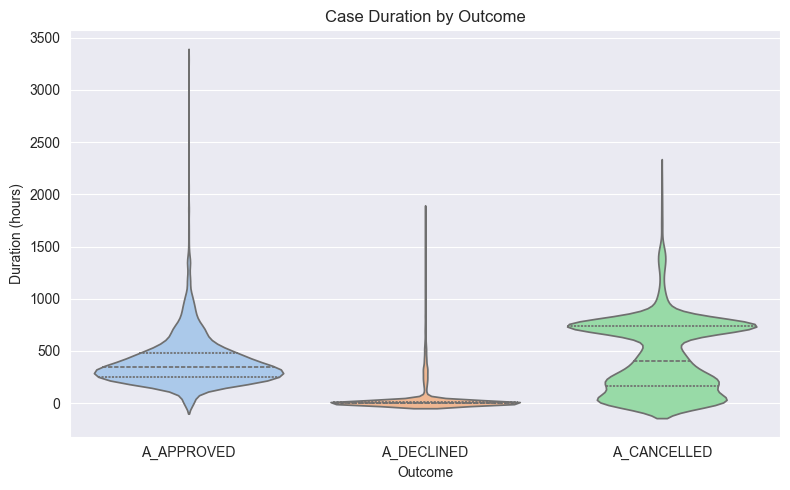

In [11]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=metrics, x="outcome", y="duration_hours", palette="pastel", legend=False, inner="quartile")
plt.title("Case Duration by Outcome")
plt.yscale("linear")
plt.xlabel("Outcome")
plt.ylabel("Duration (hours)")
plt.tight_layout()
plt.show()

### 5.2 Loan Amount by Outcome (y log scale)
Investigating how the requested loan amount varies across different outcomes

C:\Users\mdomi\AppData\Local\Temp\ipykernel_66980\2402241807.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=metrics, x="outcome", y="AMOUNT_REQ", palette="pastel", legend=False, inner="quartile")


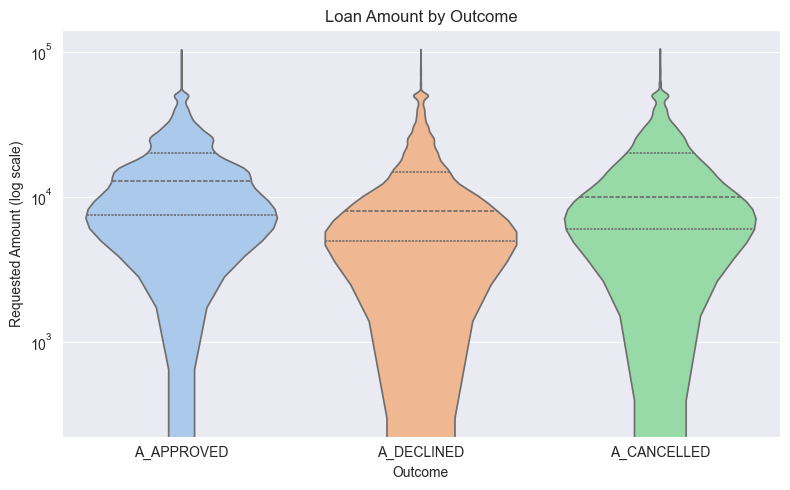

In [12]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=metrics, x="outcome", y="AMOUNT_REQ", palette="pastel", legend=False, inner="quartile")
plt.title("Loan Amount by Outcome")
plt.yscale("log")
plt.xlabel("Outcome")
plt.ylabel("Requested Amount (log scale)")
plt.tight_layout()
plt.show()

### 5.3 Rework Count by Outcome
Assessing the impact of repeated actions on the likelihood of case approval or rejection

C:\Users\mdomi\AppData\Local\Temp\ipykernel_66980\2572032428.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=metrics, x="outcome", y="rework_count", palette="pastel", legend=False, inner="quartile")


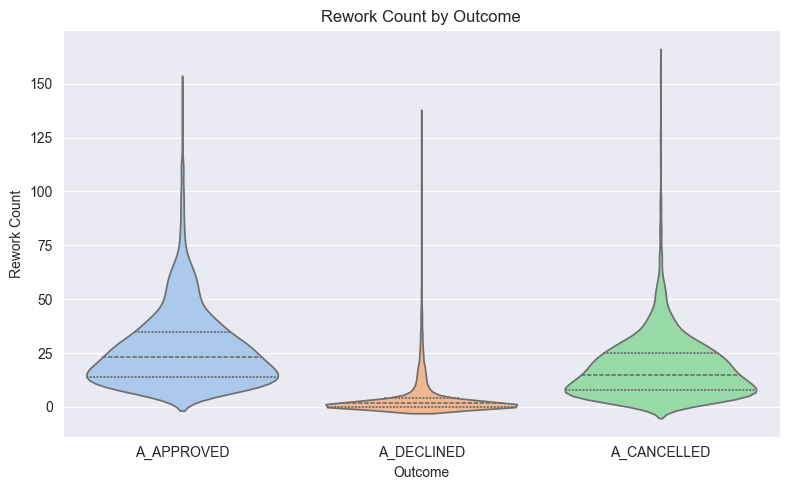

In [13]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=metrics, x="outcome", y="rework_count", palette="pastel", legend=False, inner="quartile")
plt.title("Rework Count by Outcome")
plt.xlabel("Outcome")
plt.ylabel("Rework Count")
plt.tight_layout()
plt.show()

### 5.4 Case Size (Number of Events) by Outcome
Analyzing the number of events in each case provides insights into the overall complexity and length of the application process.

C:\Users\mdomi\AppData\Local\Temp\ipykernel_66980\1205981997.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(data=metrics, x="outcome", y="num_events", palette="pastel", legend=False, inner="quartile")


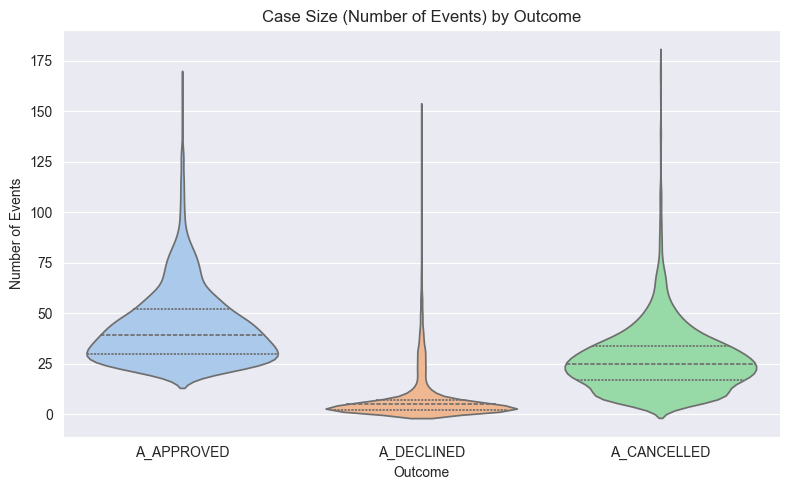

In [14]:
plt.figure(figsize=(8, 5))
sns.violinplot(data=metrics, x="outcome", y="num_events", palette="pastel", legend=False, inner="quartile")
plt.title("Case Size (Number of Events) by Outcome")
plt.xlabel("Outcome")
plt.ylabel("Number of Events")
plt.tight_layout()
plt.show()


## 6. Statistical analysis
### 6.1 Statistical Testing – Kruskal-Wallis
This code applies the Kruskal-Wallis H-test to determine whether the distributions of case duration (duration_hours) and rework count (rework_count) differ significantly across the three outcome categories (A_APPROVED, A_CANCELLED, A_DECLINED).

In [15]:
from scipy.stats import kruskal

groups = [metrics.loc[metrics["outcome"] == o, "duration_hours"] for o in valid_outcomes]
h_stat, p_val = kruskal(*groups)
print(f"Kruskal-Wallis test for duration_hours: H = {h_stat:.2f}, p = {p_val:.4f}")

groups = [metrics.loc[metrics["outcome"] == o, "rework_count"] for o in valid_outcomes]
h_stat, p_val = kruskal(*groups)
print(f"Kruskal-Wallis test for rework_count: H = {h_stat:.2f}, p = {p_val:.4f}")

Kruskal-Wallis test for duration_hours: H = 6646.58, p = 0.0000
Kruskal-Wallis test for rework_count: H = 6539.58, p = 0.0000


### 6.2 KPI analysis
Key performance indicators (KPIs) are used to assess process efficiency and highlight areas for optimization.

**Average duration per outcome**

Evaluating how processing time varies across different loan outcomes

**Average number of reworks per outcome**

Measuring the extent of repetition in cases and its relation to approval or rejection

**Max duration of manual tasks (W_ activities)**

Identifying potential bottlenecks by locating the longest manually performed tasks


In [16]:
avg_duration_kpi = metrics.groupby("outcome")["duration_hours"].mean()
print("Average case duration (in hours) by outcome:")
print(avg_duration_kpi)

avg_rework_kpi = metrics.groupby("outcome")["rework_count"].mean()
print("\nAverage rework count by outcome:")
print(avg_rework_kpi)

manual_tasks = df[df["concept:name"].str.startswith("W_")]
manual_duration = manual_tasks.groupby("case:concept:name")["time:timestamp"].agg(["min", "max"])
manual_duration["duration_hours"] = (manual_duration["max"] - manual_duration["min"]).dt.total_seconds() / 3600
manual_kpi = manual_duration["duration_hours"].max()
print(f"\nMax duration of manual tasks (W_ activities): {manual_kpi:.2f} hours")
manual_tasks = df[df["concept:name"].str.startswith("W_")]
manual_tasks.loc[:, "duration"] = manual_tasks.groupby("case:concept:name")["time:timestamp"] \
    .transform(lambda x: (x.max() - x.min()).total_seconds() / 3600)
print(manual_tasks.loc[manual_tasks["duration"].idxmax()])

Average case duration (in hours) by outcome:
outcome
A_APPROVED     401.521624
A_CANCELLED    446.287204
A_DECLINED      49.141939
Name: duration_hours, dtype: float64

Average rework count by outcome:
outcome
A_APPROVED     27.356634
A_CANCELLED    18.597435
A_DECLINED      4.300720
Name: rework_count, dtype: float64

Max duration of manual tasks (W_ activities): 3292.30 hours
org:resource                                         112
lifecycle:transition                            SCHEDULE
concept:name                      W_Completeren aanvraag
time:timestamp          2011-10-01 08:11:13.390000+00:00
case:REG_DATE           2011-10-01 08:10:30.287000+00:00
case:concept:name                                 173694
case:AMOUNT_REQ                                     7000
AMOUNT_REQ                                          7000
outcome                                       A_APPROVED
duration                                     3292.303586
Name: 68, dtype: object


C:\Users\mdomi\AppData\Local\Temp\ipykernel_66980\1059725942.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  manual_tasks.loc[:, "duration"] = manual_tasks.groupby("case:concept:name")["time:timestamp"] \


### 6.3 Correlation Analysis – Spearman Rank
Spearman’s ρ (rho) assesses the monotonic relationship between two variables, without assuming a linear or normal distribution.

In [17]:
corr, p_val = spearmanr(metrics["AMOUNT_REQ"], metrics["duration_hours"])
print(f"Spearman correlation (AMOUNT_REQ vs duration_hours): rho = {corr:.2f}, p = {p_val:.4f}")

Spearman correlation (AMOUNT_REQ vs duration_hours): rho = 0.24, p = 0.0000
